In [1]:
import numpy as np
import pandas as pd

from scipy.stats.mstats import winsorize

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("GlobalWeatherRepository.csv")
df_copy = df.copy()

In [3]:
df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [4]:
max(df['temperature_celsius']),min(df["temperature_celsius"])

(49.2, -24.8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50085 entries, 0 to 50084
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       50085 non-null  object 
 1   location_name                 50085 non-null  object 
 2   latitude                      50085 non-null  float64
 3   longitude                     50085 non-null  float64
 4   timezone                      50085 non-null  object 
 5   last_updated_epoch            50085 non-null  int64  
 6   last_updated                  50085 non-null  object 
 7   temperature_celsius           50085 non-null  float64
 8   temperature_fahrenheit        50085 non-null  float64
 9   condition_text                50085 non-null  object 
 10  wind_mph                      50085 non-null  float64
 11  wind_kph                      50085 non-null  float64
 12  wind_degree                   50085 non-null  int64  
 13  w

# Exploratory Data Analysis

In [7]:
df.describe()

,latitude,longitude,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,...,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination
count,50085.000000,50085.000000,5.008500e+04,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000,...,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000,50085.000000
mean,19.140724,22.201057,1.727009e+09,22.909057,73.237796,8.290917,13.346914,170.829011,1013.794429,29.936745,...,19.283414,518.375437,62.867008,14.189305,10.768164,23.773601,46.854915,1.659559,2.536767,48.889268
std,24.480869,65.791828,6.485993e+06,9.231627,16.616811,9.792521,15.758207,103.144730,11.372817,0.335787,...,17.477783,987.506128,37.612307,25.855003,51.579481,45.608557,141.616673,0.965359,2.488339,34.932967
min,-41.300000,-175.200000,1.715849e+09,-24.800000,-12.600000,2.200000,3.600000,1.000000,964.000000,28.470000,...,3.600000,-9999.000000,0.000000,0.000000,-9999.000000,0.185000,0.185000,1.000000,1.000000,0.000000
25%,3.750000,-6.250000,1.721307e+09,18.100000,64.600000,4.000000,6.500000,82.000000,1010.000000,29.830000,...,10.800000,220.300000,37.000000,0.900000,0.700000,4.810000,7.770000,1.000000,1.000000,14.000000
50%,17.250000,23.320000,1.727085e+09,25.300000,77.500000,6.900000,11.200000,164.000000,1013.000000,29.910000,...,17.000000,312.650000,59.000000,3.000000,2.100000,12.200000,18.870000,1.000000,2.000000,49.000000
75%,40.400000,50.580000,1.732612e+09,28.900000,84.100000,11.600000,18.700000,258.000000,1017.000000,30.030000,...,25.700000,480.700000,83.700000,14.615000,7.955000,26.700000,42.550000,2.000000,3.000000,83.000000
max,64.150000,179.220000,1.738147e+09,49.200000,120.600000,1841.200000,2963.200000,360.000000,3006.000000,88.770000,...,2970.400000,38879.398000,480.700000,427.700000,521.330000,1614.100000,5858.020000,6.000000,10.000000,100.000000


In [8]:
df.isnull().sum()

country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

No Null Values in the dataset

## Correlation Heatmap

C:\Users\Aditya Gupta\AppData\Local\Temp\ipykernel_14236\3815630845.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)


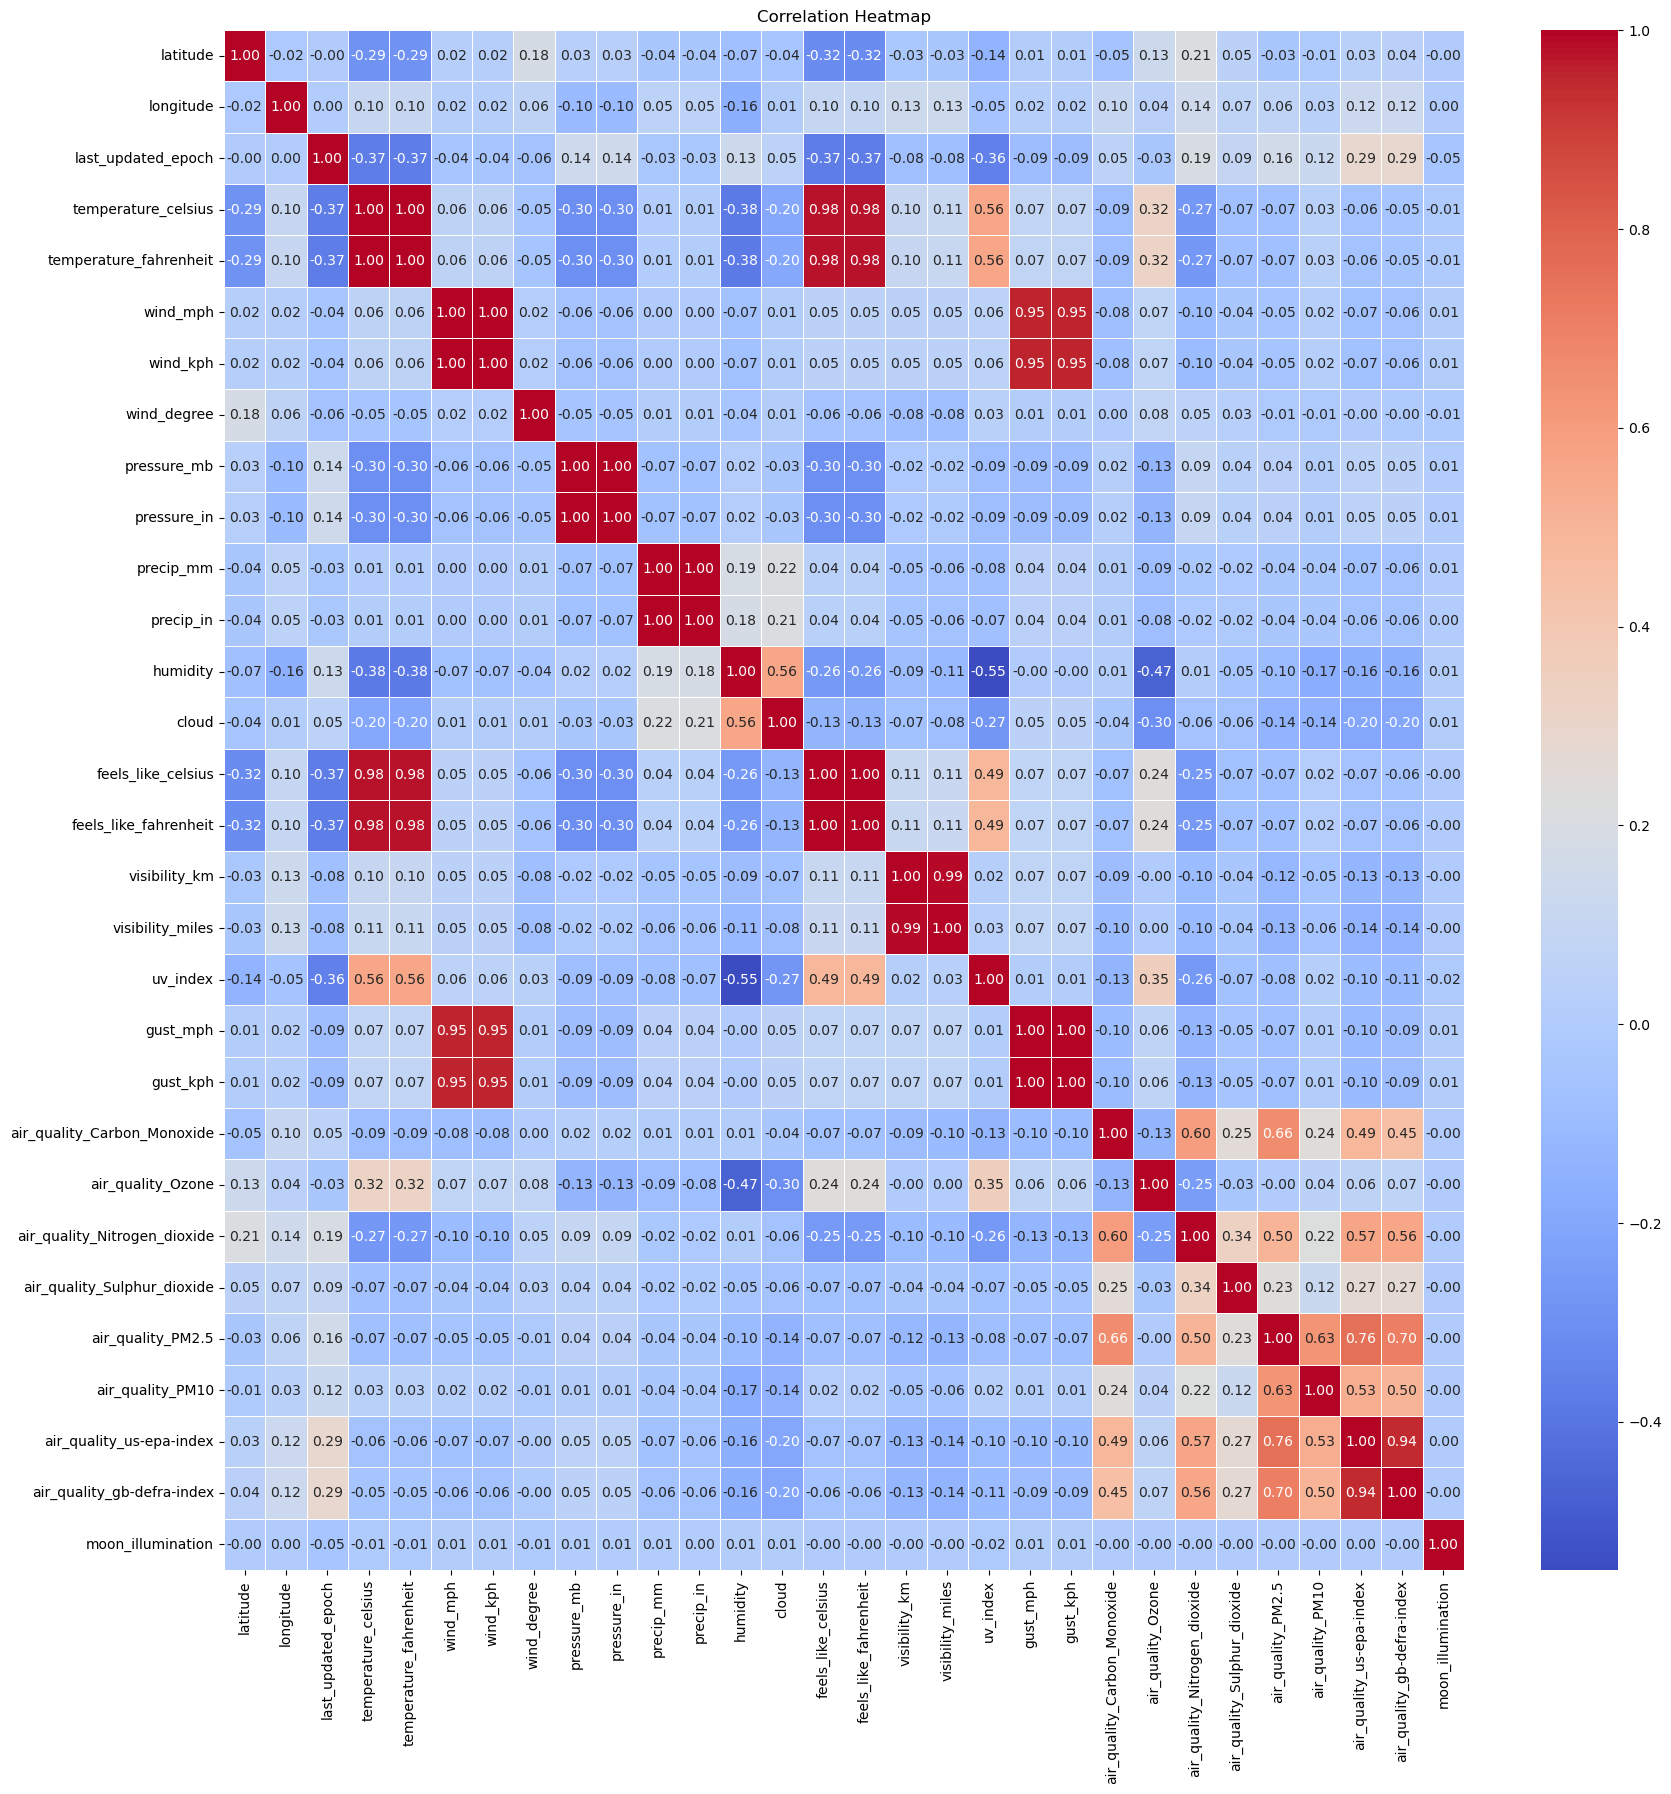

In [9]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [10]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols, len(numerical_cols)

(['latitude',
  'longitude',
  'last_updated_epoch',
  'temperature_celsius',
  'temperature_fahrenheit',
  'wind_mph',
  'wind_kph',
  'wind_degree',
  'pressure_mb',
  'pressure_in',
  'precip_mm',
  'precip_in',
  'humidity',
  'cloud',
  'feels_like_celsius',
  'feels_like_fahrenheit',
  'visibility_km',
  'visibility_miles',
  'uv_index',
  'gust_mph',
  'gust_kph',
  'air_quality_Carbon_Monoxide',
  'air_quality_Ozone',
  'air_quality_Nitrogen_dioxide',
  'air_quality_Sulphur_dioxide',
  'air_quality_PM2.5',
  'air_quality_PM10',
  'air_quality_us-epa-index',
  'air_quality_gb-defra-index',
  'moon_illumination'],
 30)

## Distribution of all Features

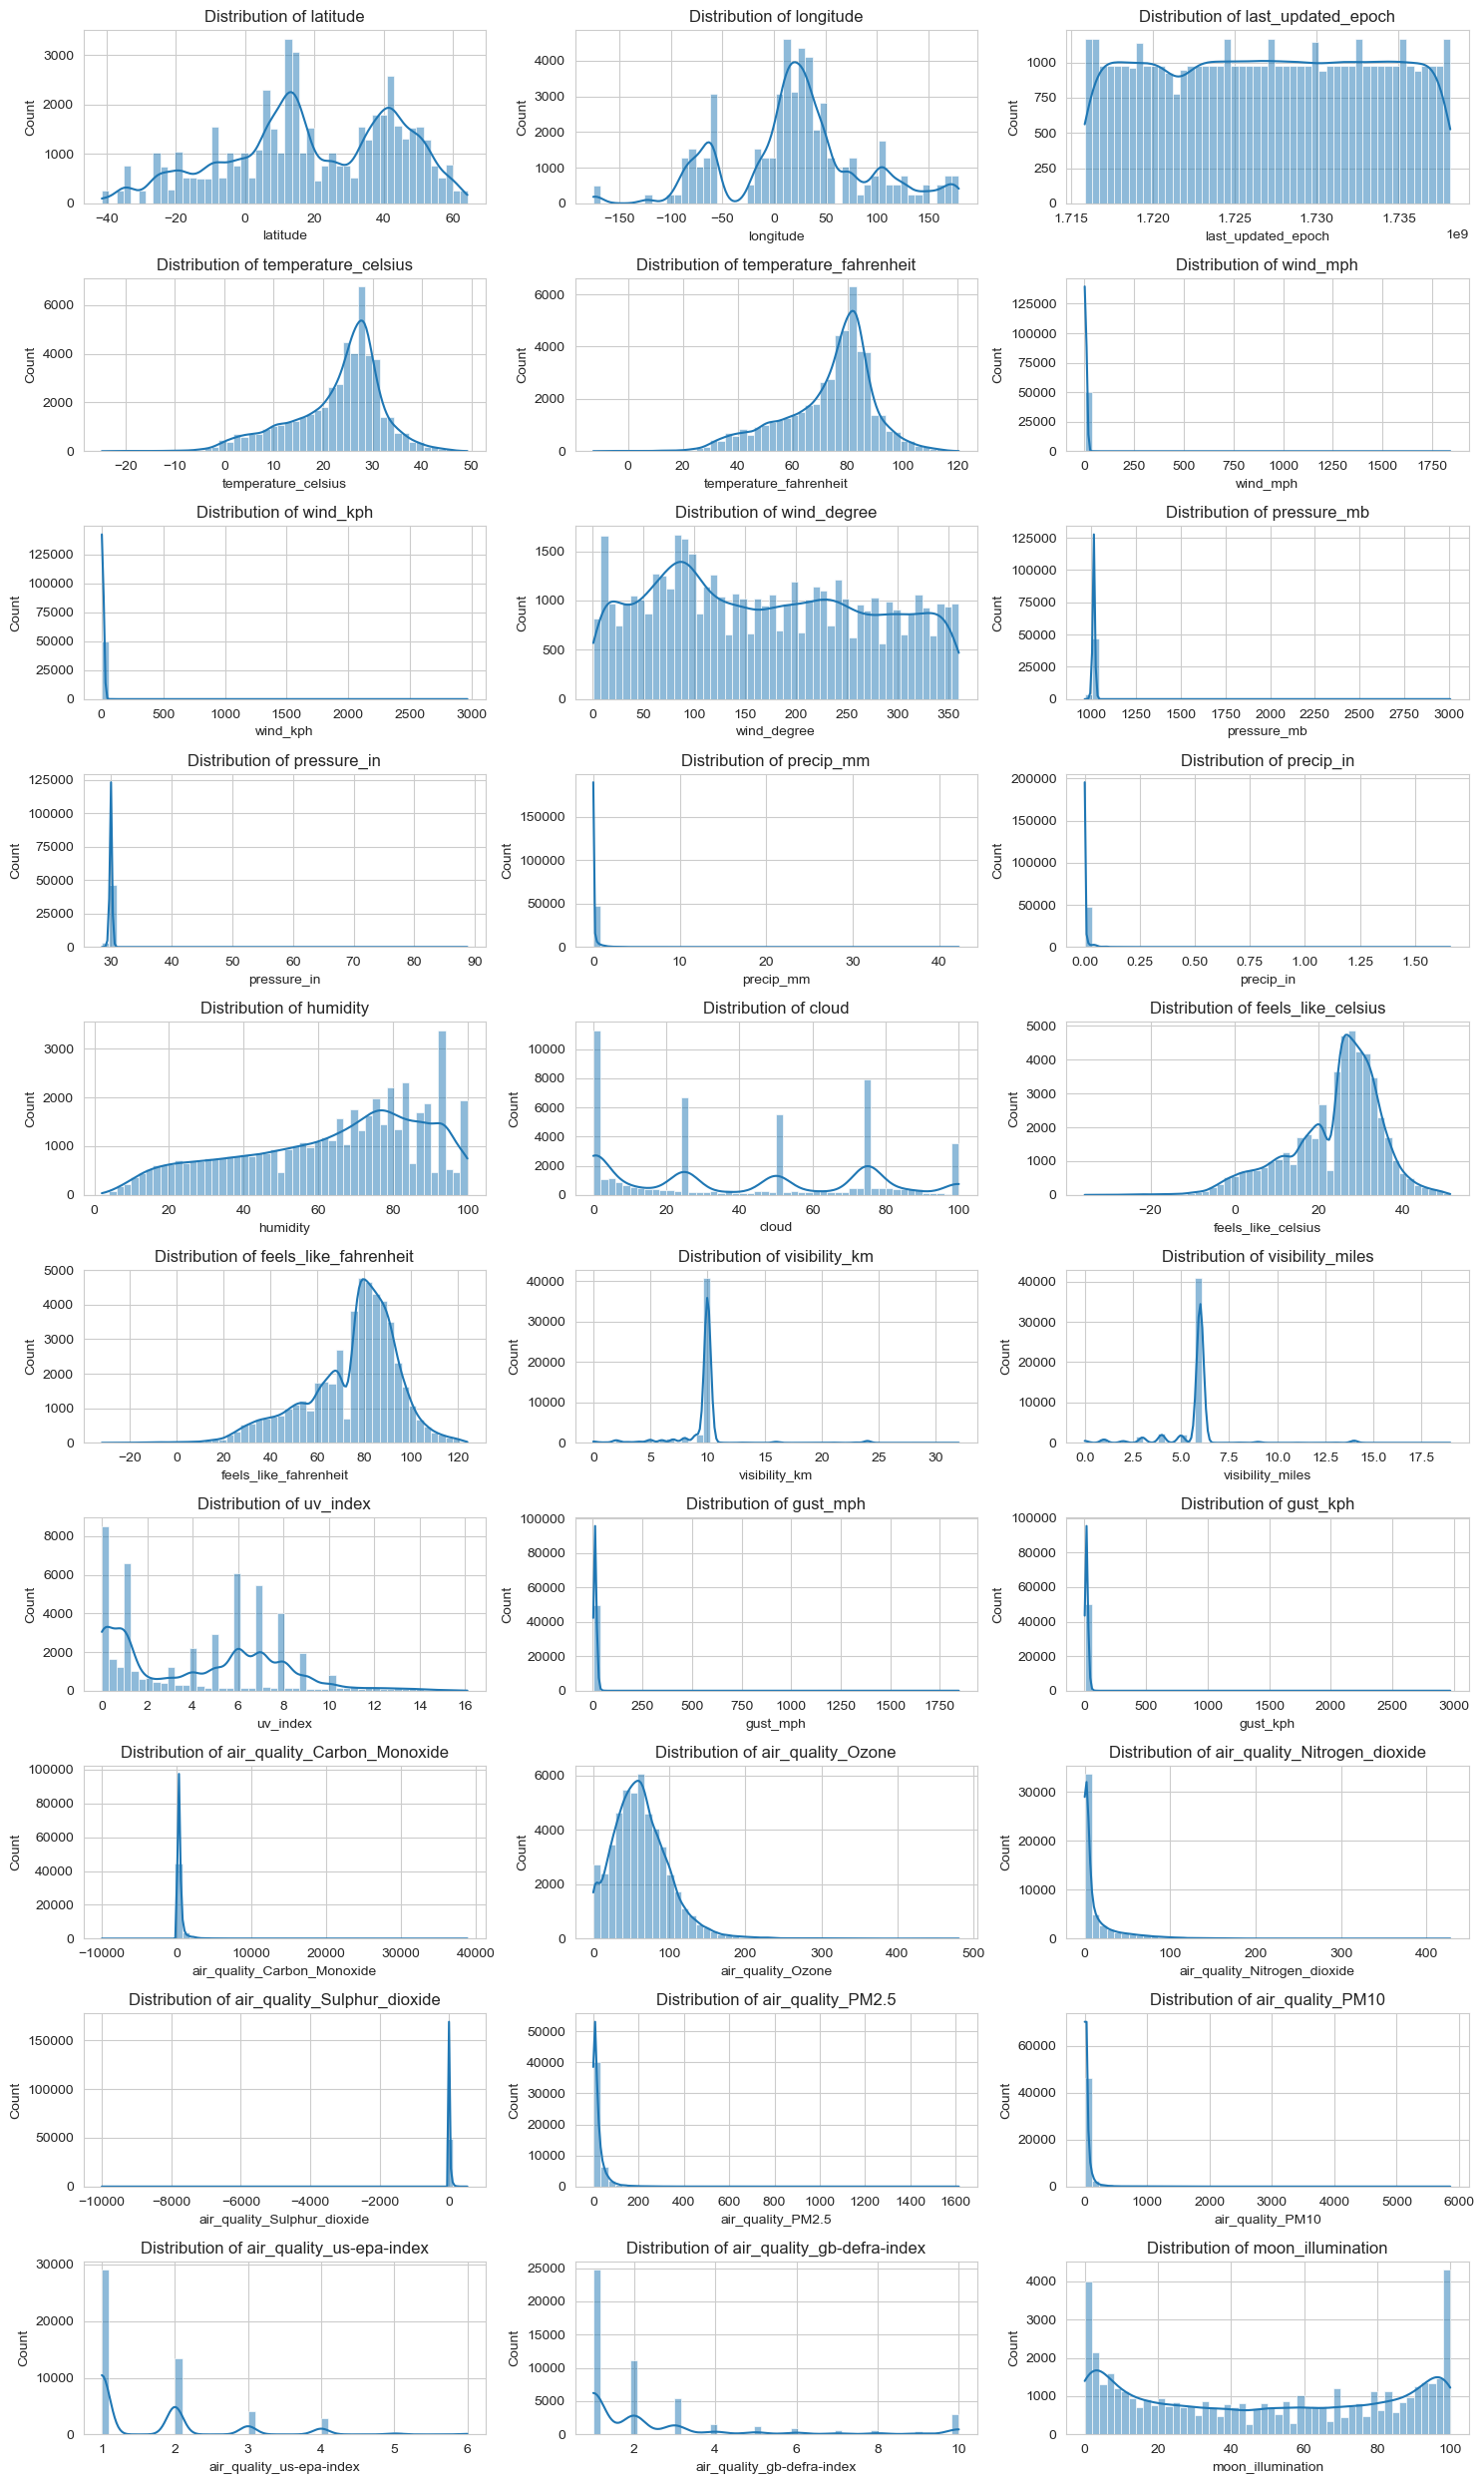

In [11]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 25))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df_copy[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Plots before dealing with outliers 

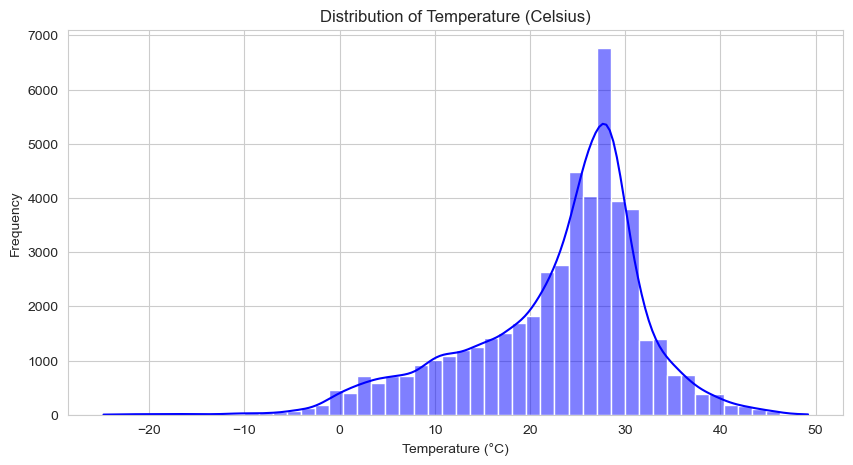

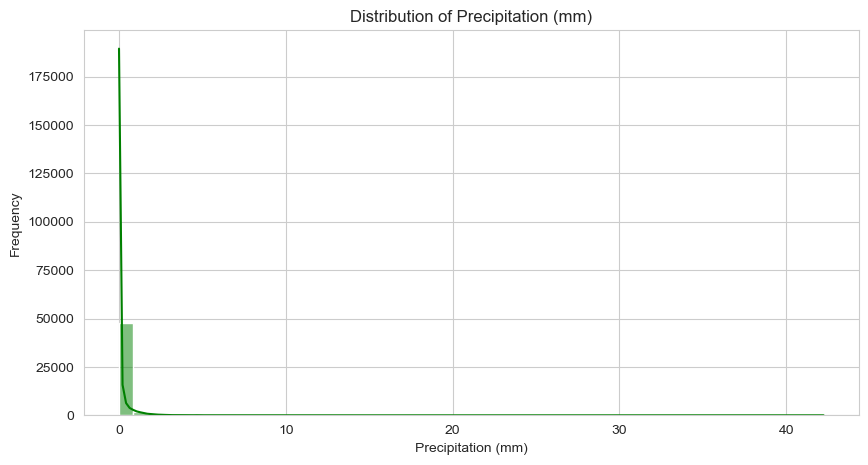

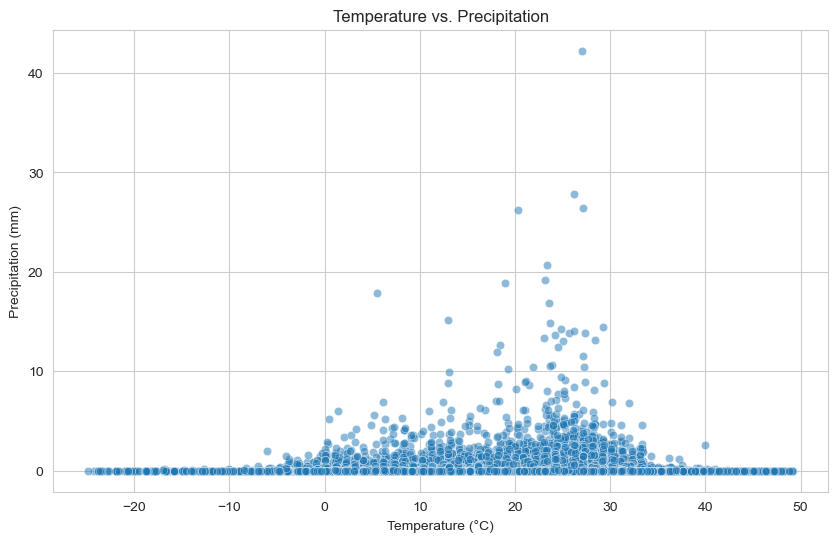

In [12]:
# Plot Temperature Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["temperature_celsius"], bins=50, kde=True, color="blue")
plt.title("Distribution of Temperature (Celsius)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Plot Precipitation Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["precip_mm"], bins=50, kde=True, color="green")
plt.title("Distribution of Precipitation (mm)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Temperature vs. Precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["temperature_celsius"], y=df["precip_mm"], alpha=0.5)
plt.title("Temperature vs. Precipitation")
plt.xlabel("Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.show()

C:\Users\Aditya Gupta\AppData\Local\Temp\ipykernel_14236\1362951087.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_time_series_daily = df_time_series.groupby("date").mean().reset_index()


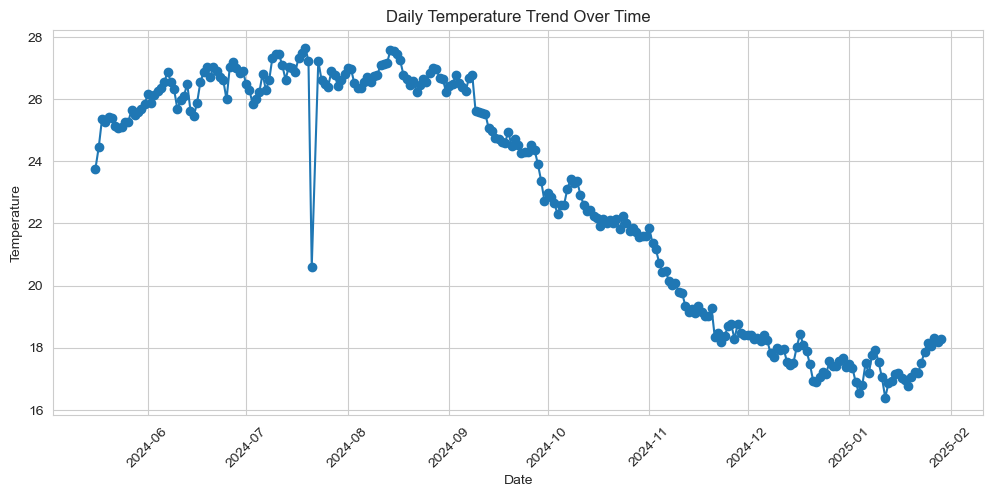

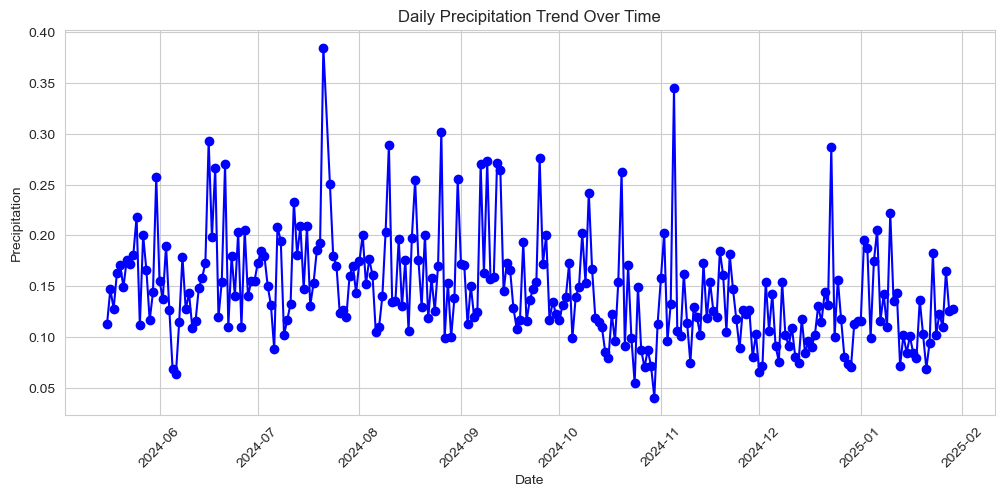

In [13]:
# Aggregate the data by date (daily mean values for time series analysis)
df_time_series = df.copy()
df_time_series["last_updated"] = pd.to_datetime(df_time_series['last_updated'])
df_time_series["date"] = df_time_series["last_updated"].dt.date  # Extract date
df_time_series_daily = df_time_series.groupby("date").mean().reset_index()

# Plot Temperature Trend Over Time
plt.figure(figsize=(12, 5))
plt.plot(df_time_series_daily["date"], df_time_series_daily["temperature_celsius"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Daily Temperature Trend Over Time")
plt.xticks(rotation=45)
plt.show()

# Plot Precipitation Trend Over Time
plt.figure(figsize=(12, 5))
plt.plot(df_time_series_daily["date"], df_time_series_daily["precip_mm"], marker="o", linestyle="-", color="blue")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Daily Precipitation Trend Over Time")
plt.xticks(rotation=45)
plt.show()

# Dealing with Outliers

## Dealing with outliers by using IQR and clipping

In [14]:
# Detect outliers using IQR method
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values outside of 1.5 * IQR range
outliers = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).sum()

outliers

latitude                           0
longitude                       3853
last_updated_epoch                 0
temperature_celsius             1544
temperature_fahrenheit          1518
wind_mph                         543
wind_kph                         654
wind_degree                        0
pressure_mb                     3343
pressure_in                     3434
precip_mm                       9564
precip_in                       8043
humidity                           0
cloud                              0
feels_like_celsius              1312
feels_like_fahrenheit           1314
visibility_km                   9314
visibility_miles                9231
uv_index                           1
gust_mph                        1009
gust_kph                        1022
air_quality_Carbon_Monoxide     4602
air_quality_Ozone                980
air_quality_Nitrogen_dioxide    6538
air_quality_Sulphur_dioxide     7396
air_quality_PM2.5               4183
air_quality_PM10                5100
a

In [15]:
# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_iqr_clip = df.copy()
# Cap extreme outliers to the lower and upper bounds
df_iqr_clip[numerical_cols] = df_iqr_clip[numerical_cols].clip(lower=lower_bound, upper=upper_bound, axis=1)

# Verify if outliers are handled (Recalculate outlier counts after capping)
iqr_outliers_after = ((df_iqr_clip[numerical_cols] < (Q1 - 1.5 * IQR)) | (df_iqr_clip[numerical_cols] > (Q3 + 1.5 * IQR))).sum()

iqr_outliers_after

latitude                        0
longitude                       0
last_updated_epoch              0
temperature_celsius             0
temperature_fahrenheit          0
wind_mph                        0
wind_kph                        0
wind_degree                     0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Nitrogen_dioxide    0
air_quality_Sulphur_dioxide     0
air_quality_PM2.5               0
air_quality_PM10                0
air_quality_us-epa-index        0
air_quality_gb-defra-index      0
moon_illuminat

In [16]:
# Normalize numerical columns using Min-Max scaling
for col in numerical_cols:
    df_iqr_clip[col] = (df_iqr_clip[col] - df_iqr_clip[col].min()) / (df_iqr_clip[col].max() - df_iqr_clip[col].min())

In [17]:
df_iqr_clip

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,0.719014,0.706823,Asia/Kabul,0.0,2024-05-16 13:15,0.571759,0.569872,Partly Cloudy,...,0.138416,0.279420,0.0,0.0,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,0.55
1,Albania,Tirana,0.783594,0.489684,Europe/Tirane,0.0,2024-05-16 10:45,0.395833,0.395513,Partly cloudy,...,0.015417,0.019199,0.0,0.0,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,0.55
2,Algeria,Algiers,0.740256,0.415911,Africa/Algiers,0.0,2024-05-16 09:45,0.488426,0.487821,Sunny,...,0.172115,0.192680,0.0,0.0,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,0.55
3,Andorra,Andorra La Vella,0.794689,0.409181,Europe/Andorra,0.0,2024-05-16 10:45,0.101852,0.101923,Light drizzle,...,0.008677,0.007563,0.0,0.0,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,0.55
4,Angola,Luanda,0.307824,0.460694,Africa/Luanda,0.0,2024-05-16 09:45,0.557870,0.557051,Partly cloudy,...,1.000000,1.000000,1.0,1.0,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50080,Venezuela,Caracas,0.491228,0.108122,America/Caracas,1.0,2025-01-29 06:30,0.493056,0.492949,Partly cloudy,...,0.146504,0.115460,0.0,0.0,06:51 AM,06:31 PM,06:59 AM,06:52 PM,New Moon,0.00
50081,Vietnam,Hanoi,0.591117,0.868137,Asia/Bangkok,1.0,2025-01-29 17:30,0.395833,0.395513,Sunny,...,1.000000,1.000000,1.0,1.0,06:34 AM,05:45 PM,06:24 AM,05:34 PM,New Moon,0.01
50082,Yemen,Sanaa,0.537266,0.596963,Asia/Aden,1.0,2025-01-29 13:30,0.442130,0.440385,Sunny,...,0.370935,0.931507,0.4,0.2,06:33 AM,06:00 PM,06:28 AM,06:01 PM,New Moon,0.01
50083,Zambia,Lusaka,0.245456,0.526915,Africa/Lusaka,1.0,2025-01-29 12:30,0.414352,0.413462,Light rain shower,...,0.049874,0.031311,0.0,0.0,05:56 AM,06:44 PM,05:38 AM,06:57 PM,New Moon,0.01


## Plots after dealing with outliers through clipping

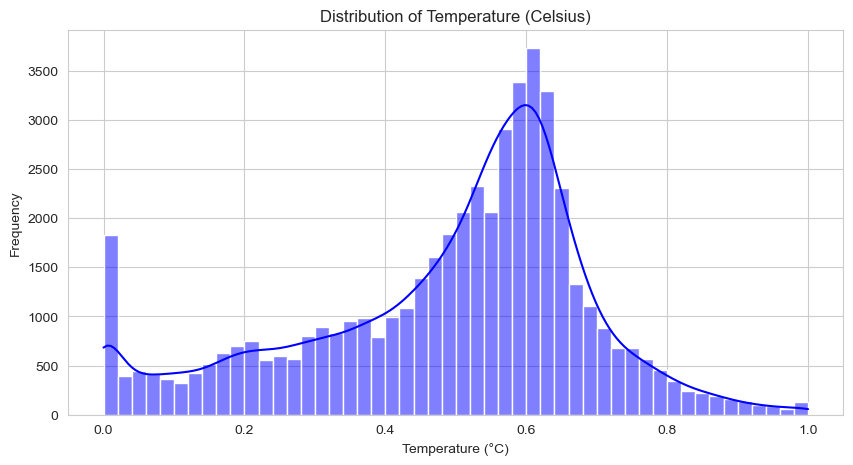

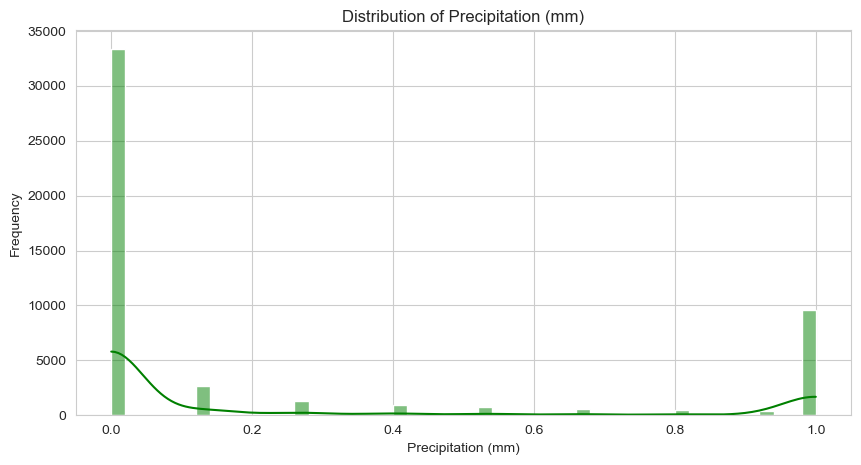

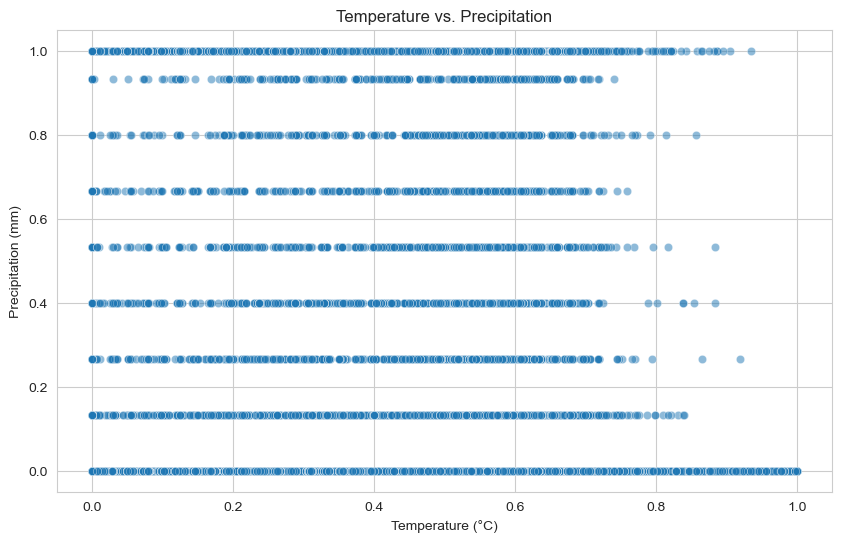

In [18]:
# Plot Temperature Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_iqr_clip["temperature_celsius"], bins=50, kde=True, color="blue")
plt.title("Distribution of Temperature (Celsius)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Plot Precipitation Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_iqr_clip["precip_mm"], bins=50, kde=True, color="green")
plt.title("Distribution of Precipitation (mm)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Temperature vs. Precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_iqr_clip["temperature_celsius"], y=df_iqr_clip["precip_mm"], alpha=0.5)
plt.title("Temperature vs. Precipitation")
plt.xlabel("Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.show()

## Dealing with outliers using Winsorization

In [19]:
# Detect outliers using IQR method
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values outside of 1.5 * IQR range
outliers = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).sum()

# Display outlier count per column
outliers

latitude                           0
longitude                       3853
last_updated_epoch                 0
temperature_celsius             1544
temperature_fahrenheit          1518
wind_mph                         543
wind_kph                         654
wind_degree                        0
pressure_mb                     3343
pressure_in                     3434
precip_mm                       9564
precip_in                       8043
humidity                           0
cloud                              0
feels_like_celsius              1312
feels_like_fahrenheit           1314
visibility_km                   9314
visibility_miles                9231
uv_index                           1
gust_mph                        1009
gust_kph                        1022
air_quality_Carbon_Monoxide     4602
air_quality_Ozone                980
air_quality_Nitrogen_dioxide    6538
air_quality_Sulphur_dioxide     7396
air_quality_PM2.5               4183
air_quality_PM10                5100
a

In [20]:
df_winsorized = df.copy()

for col in numerical_cols:
    df_winsorized[col] = winsorize(df[col], limits=[0.01, 0.01])  # Capping at 1st and 99th percentile

# Verify changes by checking new outlier count
Q1_winsorized = df_winsorized[numerical_cols].quantile(0.25)
Q3_winsorized = df_winsorized[numerical_cols].quantile(0.75)
IQR_winsorized = Q3_winsorized - Q1_winsorized

# Verify if outliers are handled (Recalculate outlier counts after capping)
winsorized_outliers_after = ((df_winsorized[numerical_cols] < (Q1_winsorized - 1.5 * IQR_winsorized)) | (df_winsorized[numerical_cols] > (Q3_winsorized + 1.5 * IQR_winsorized))).sum()

winsorized_outliers_after

latitude                           0
longitude                       3853
last_updated_epoch                 0
temperature_celsius             1451
temperature_fahrenheit          1438
wind_mph                         543
wind_kph                         654
wind_degree                        0
pressure_mb                     3343
pressure_in                     3434
precip_mm                       9564
precip_in                       8043
humidity                           0
cloud                              0
feels_like_celsius              1308
feels_like_fahrenheit           1310
visibility_km                   9314
visibility_miles                9231
uv_index                           0
gust_mph                        1009
gust_kph                        1022
air_quality_Carbon_Monoxide     4601
air_quality_Ozone                980
air_quality_Nitrogen_dioxide    6538
air_quality_Sulphur_dioxide     7395
air_quality_PM2.5               4183
air_quality_PM10                5100
a

## Plots after dealing with outliers through Winsorization

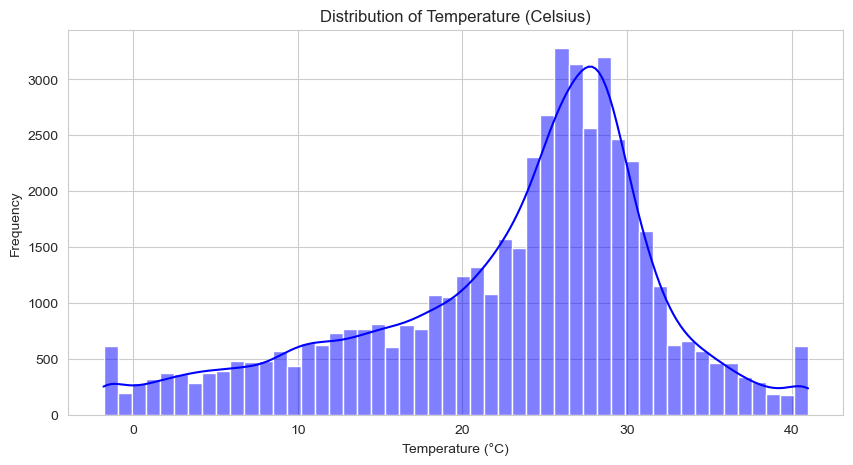

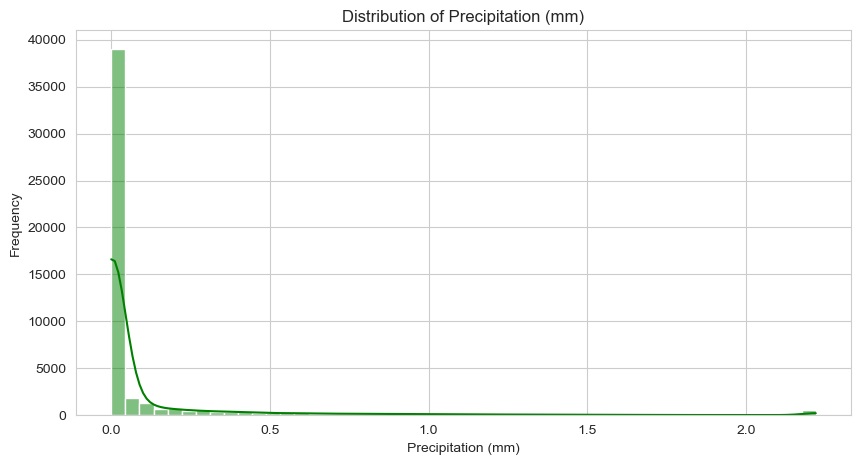

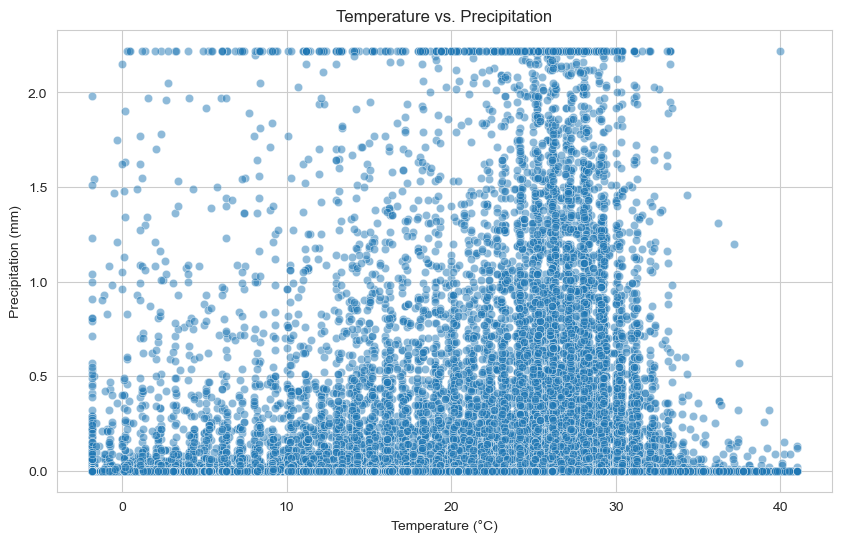

In [21]:
# Plot Temperature Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_winsorized["temperature_celsius"], bins=50, kde=True, color="blue")
plt.title("Distribution of Temperature (Celsius)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Plot Precipitation Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_winsorized["precip_mm"], bins=50, kde=True, color="green")
plt.title("Distribution of Precipitation (mm)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: Temperature vs. Precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_winsorized["temperature_celsius"], y=df_winsorized["precip_mm"], alpha=0.5)
plt.title("Temperature vs. Precipitation")
plt.xlabel("Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.show()

## Determining Skewness

In [22]:
# Compute skewness for all numerical columns
skewness_values = df[numerical_cols].skew()

# Convert to DataFrame for better readability
skewness_df = pd.DataFrame(skewness_values, columns=["Skewness"])

skewness_df

,Skewness
latitude,-0.305923
longitude,0.001597
last_updated_epoch,-0.015773
temperature_celsius,-0.880714
temperature_fahrenheit,-0.880644
wind_mph,131.319481
wind_kph,131.362487
wind_degree,0.151367
pressure_mb,107.361091
pressure_in,107.433063


Since most of the columns have skewed data and so it would be better to winsorize the outliers.

In [23]:
df = df_winsorized.copy()

C:\Users\Aditya Gupta\AppData\Local\Temp\ipykernel_14236\3955657270.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_time_series_daily = df_time_series.groupby("date").mean().reset_index()


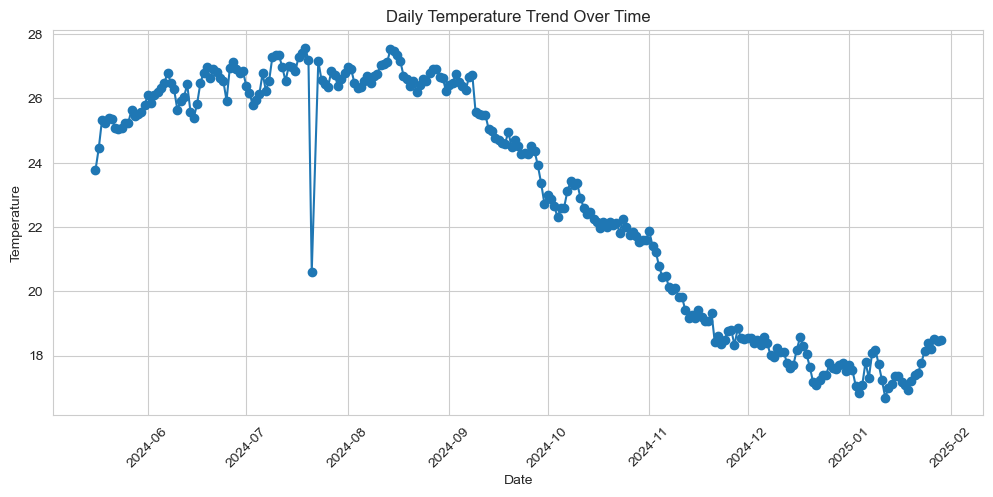

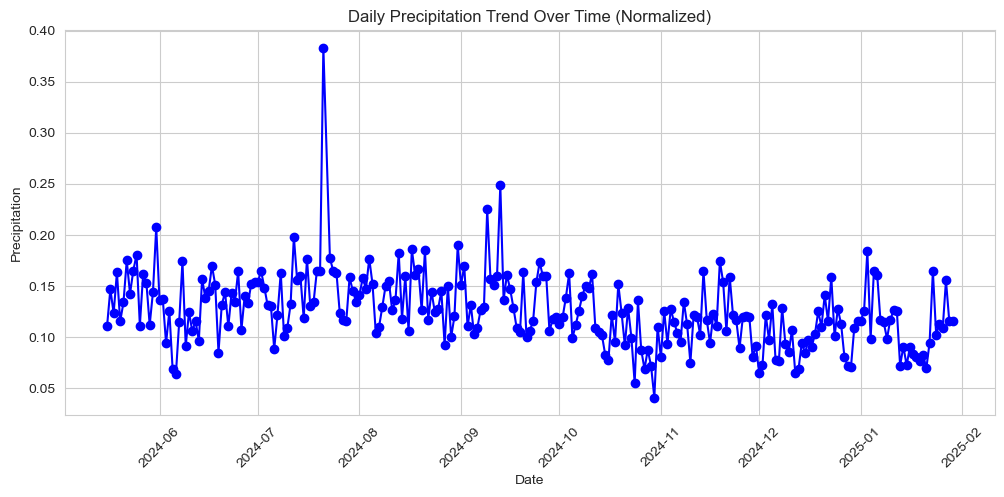

In [24]:
# Aggregate the data by date (daily mean values for time series analysis)
df_time_series = df.copy()
df_time_series["last_updated"] = pd.to_datetime(df_time_series['last_updated'])
df_time_series["date"] = df_time_series["last_updated"].dt.date  # Extract date
df_time_series_daily = df_time_series.groupby("date").mean().reset_index()

# Plot Temperature Trend Over Time
plt.figure(figsize=(12, 5))
plt.plot(df_time_series_daily["date"], df_time_series_daily["temperature_celsius"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Daily Temperature Trend Over Time")
plt.xticks(rotation=45)
plt.show()

# Plot Precipitation Trend Over Time
plt.figure(figsize=(12, 5))
plt.plot(df_time_series_daily["date"], df_time_series_daily["precip_mm"], marker="o", linestyle="-", color="blue")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Daily Precipitation Trend Over Time (Normalized)")
plt.xticks(rotation=45)
plt.show()

In [25]:
# Normalize numerical columns using Min-Max scaling
for col in numerical_cols:
    if col=="temperature_celsius":
        temp_max = df_winsorized[col].max()
        temp_min = df_winsorized[col].min()
    scaler = MinMaxScaler()
    df_winsorized[[col]] = scaler.fit_transform(df_winsorized[[col]])

In [26]:
# Convert last_updated to datetime format (if not already done)
df["last_updated"] = pd.to_datetime(df["last_updated"])

# Sort dataset by time for time series analysis
df = df.sort_values(by="last_updated")

# Selecting relevant columns for forecasting (temperature over time)
time_series_data = df[["last_updated", "temperature_celsius"]]

# Set last_updated as index
time_series_data.set_index("last_updated", inplace=True)

# Resample to daily mean temperature (if multiple entries per day exist)
time_series_daily = time_series_data.resample('D').mean()

display(time_series_daily)

,temperature_celsius
last_updated,
2024-05-16,23.761905
2024-05-17,24.446154
2024-05-18,25.328780
2024-05-19,25.239175
2024-05-20,25.397436
...,...
2025-01-25,18.382564
2025-01-26,18.198462
2025-01-27,18.508718


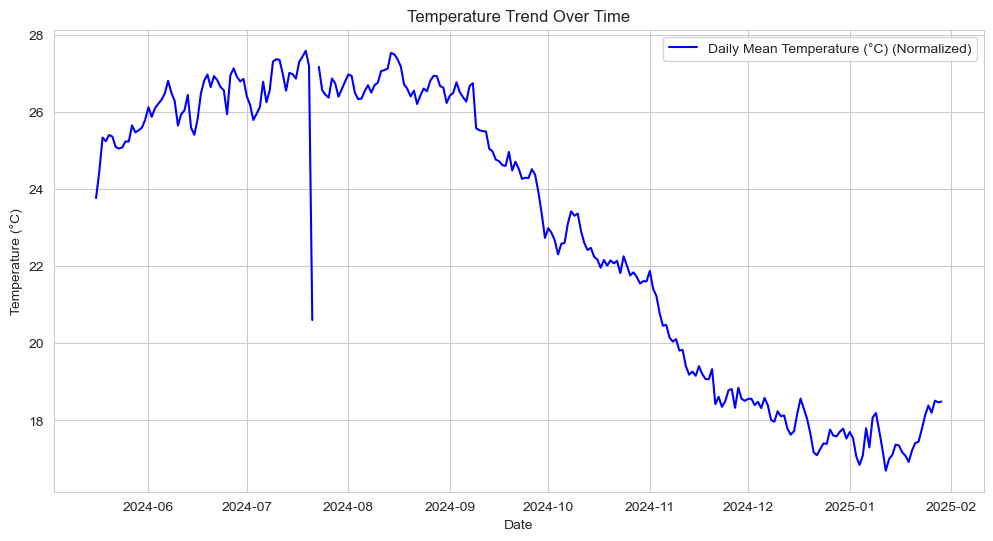

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(time_series_daily, label="Daily Mean Temperature (°C) (Normalized)", color="blue")
plt.title("Temperature Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

# Determining ARIMA parameters 

<Figure size 1000x500 with 0 Axes>

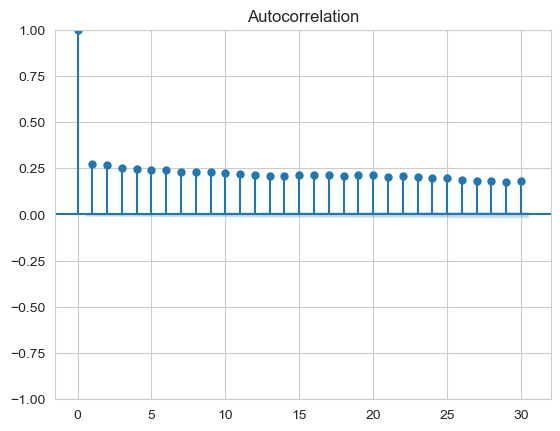

<Figure size 1000x500 with 0 Axes>

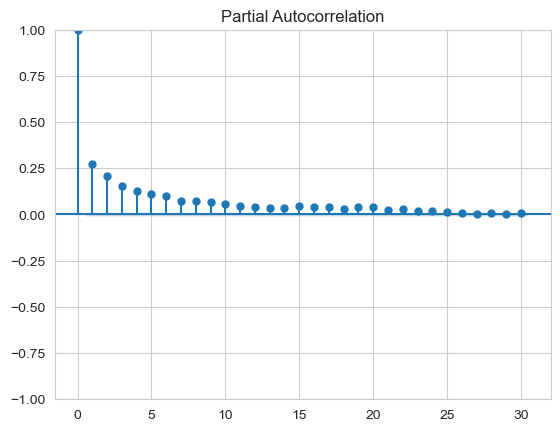

In [28]:
df_plotting = df.copy()
df_plotting.set_index('last_updated', inplace=True)

plt.figure(figsize=(10, 5))
plot_acf(df_plotting['temperature_celsius'], lags=30)  
plt.show()

plt.figure(figsize=(10, 5))
plot_pacf(df_plotting['temperature_celsius'], lags=30) 
plt.show()

# ARIMA Model and Evaluation

In [29]:
# Split Data
train_data = time_series_daily[:'2025-01-22']
test_data = time_series_daily['2025-01-23':'2025-01-29']

# Fit ARIMA Model
arima_model = ARIMA(train_data, order=(5,1,2))
fitted_arima_model = arima_model.fit()

# Forecast for test period
forecast_steps = len(test_data)
forecast_arima = fitted_arima_model.forecast(steps=forecast_steps)

# Extract actual vs. predicted values
actual_values_arima = test_data.values.flatten()
predicted_values_arima = forecast_arima.values

# Get min and max temperature from the original dataset (before scaling)
#temp_min = df_copy["temperature_celsius"].min()
#temp_max = df_copy["temperature_celsius"].max()


# Compute Corrected Metrics after inverse transformation
mae_arima_corrected = mean_absolute_error(actual_values_arima, predicted_values_arima)
rmse_arima_corrected = np.sqrt(mean_squared_error(actual_values_arima, predicted_values_arima))

print("Corrected ARIMA MAE:", mae_arima_corrected)
print("Corrected ARIMA RMSE:", rmse_arima_corrected)
print("Average Forecasted Temperatures for Jan 23 - Jan 29:\n", predicted_values_arima)
print("Actual Temperatures for Jan 23 - Jan 29:\n", actual_values_arima)

Corrected ARIMA MAE: 0.9678221548340323
Corrected ARIMA RMSE: 1.002382024281664
Average Forecasted Temperatures for Jan 23 - Jan 29:
 [17.35577059 17.28597929 17.29177781 17.3042803  17.31026155 17.31019193
 17.30754228]
Actual Temperatures for Jan 23 - Jan 29:
 [17.76974359 18.12769231 18.3825641  18.19846154 18.50871795 18.46701571
 18.48636364]
